In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from q_env_config_edu_example import (
    q_env_config as gate_q_env_config,
)
from quantumenvironment import QuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

from ppo_while_not_met_baseline import make_train_ppo
from helper_functions import load_from_pickle, load_from_yaml_file

import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Circuit context
Circuit context


/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/q_env_config_edu_example.py:110: UserWarning: No backend was provided, State vector simulation will be used
  warnings.warn("No backend was provided, State vector simulation will be used")


In [2]:
gate_q_env_config.n_shots

1

In [3]:
q_env = QuantumEnvironment(gate_q_env_config)
q_env = RescaleAction(q_env, -1.0, 1.0)
q_env = ClipAction(q_env)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/helper_functions.py:1708: UserWarning: No Backend was provided, using default values for dt, coupling_map, basis_gates and instruction_durations
  warnings.warn(


Checking reward to adjust C Factor...
fidelity access False
Starting simulation benchmark...
State fidelity: 0.49982934843703236
Finished simulation benchmark
Sending Estimator job...
SparsePauliOp(['I', 'Y', 'Z'],
              coeffs=[ 1.        +0.j, -1.41421356+0.j,  1.41421356+0.j])
Finished Estimator job
C Factor adjusted to 1.5


In [4]:
q_env.unwrapped.target.dm

DensityMatrix([[0.85355339+0.j        , 0.        +0.35355339j],
               [0.        -0.35355339j, 0.14644661+0.j        ]],
              dims=(2,))


In [7]:
all_data = {}

In [6]:
target_fidelities = [0.99, 0.999, 0.9999]
lookback_window = 8
max_hardware_runtime = 30

dir_name = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/range_1_to_250/'

In [8]:
batch_size = [1] + list(range(25, 251, 25))
# List starting from 250 and then 225, 200, ..., 25 in steps of -25
sample_Paulis = list(range(250, 24, -25)) + [1]

for seed in [3]:

    all_data = load_from_pickle('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/range_1_to_250/seed_3/state_preparation_target_state-1_bs225_sP25.pickle') #{}
    for bs, sp in [(250, 1)]: #zip(batch_size, sample_Paulis):

        q_env = QuantumEnvironment(gate_q_env_config)
        q_env = ClipAction(q_env)
        q_env = RescaleAction(q_env, -1.0, 1.0)

        q_env.unwrapped.batch_size = int(bs)
        q_env.unwrapped.sampling_Pauli_space = int(sp)

        print(f"batchsize: {q_env.unwrapped.batch_size}, sample_Paulis: {q_env.unwrapped.sampling_Pauli_space}")

        path_agent_config = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml'
        agent_config = load_from_yaml_file(path_agent_config)

        train_function = make_train_ppo(agent_config, q_env)

        training_results = train_function(
            target_fidelities = target_fidelities,
            lookback_window = lookback_window,
            max_hardware_runtime = max_hardware_runtime,
            std_actions_eps = 1e-3,
            plot_real_time = False,
            print_debug = False,
            num_prints = 40,
        )

        all_data[seed][(bs, sp)] = training_results

        sub_dir_seed = f'seed_{seed}/'
        file_name = f'state_preparation_target_state-1_bs{bs}_sP{sp}.pickle'
        file_path = dir_name + sub_dir_seed + file_name

        with open(file_path, "wb") as f:
            pickle.dump(all_data, f)
        

Total Updates applied: 760
Total Shots applied: 190,000


In [32]:
# # save all_data as pickel file
# # Specify the file path where you want to save the pickle file
# file_path = "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/educational_example_target_state-0.25pi-state_tradeoff_samplePaulis_batchsize_range_1_to_250_3seeds.pickle"

# # Save the all_data variable as a pickle file
# with open(file_path, "wb") as f:
#     pickle.dump(all_data, f)

NameError: name 'all_data' is not defined

In [39]:
file_path = "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/range_1_to_100/educational_example_target_state-0.25pi-state_tradeoff_samplePaulis_batchsize_range_1-100_3seeds.pickle"
multi_seed_dict = load_from_pickle(file_path)

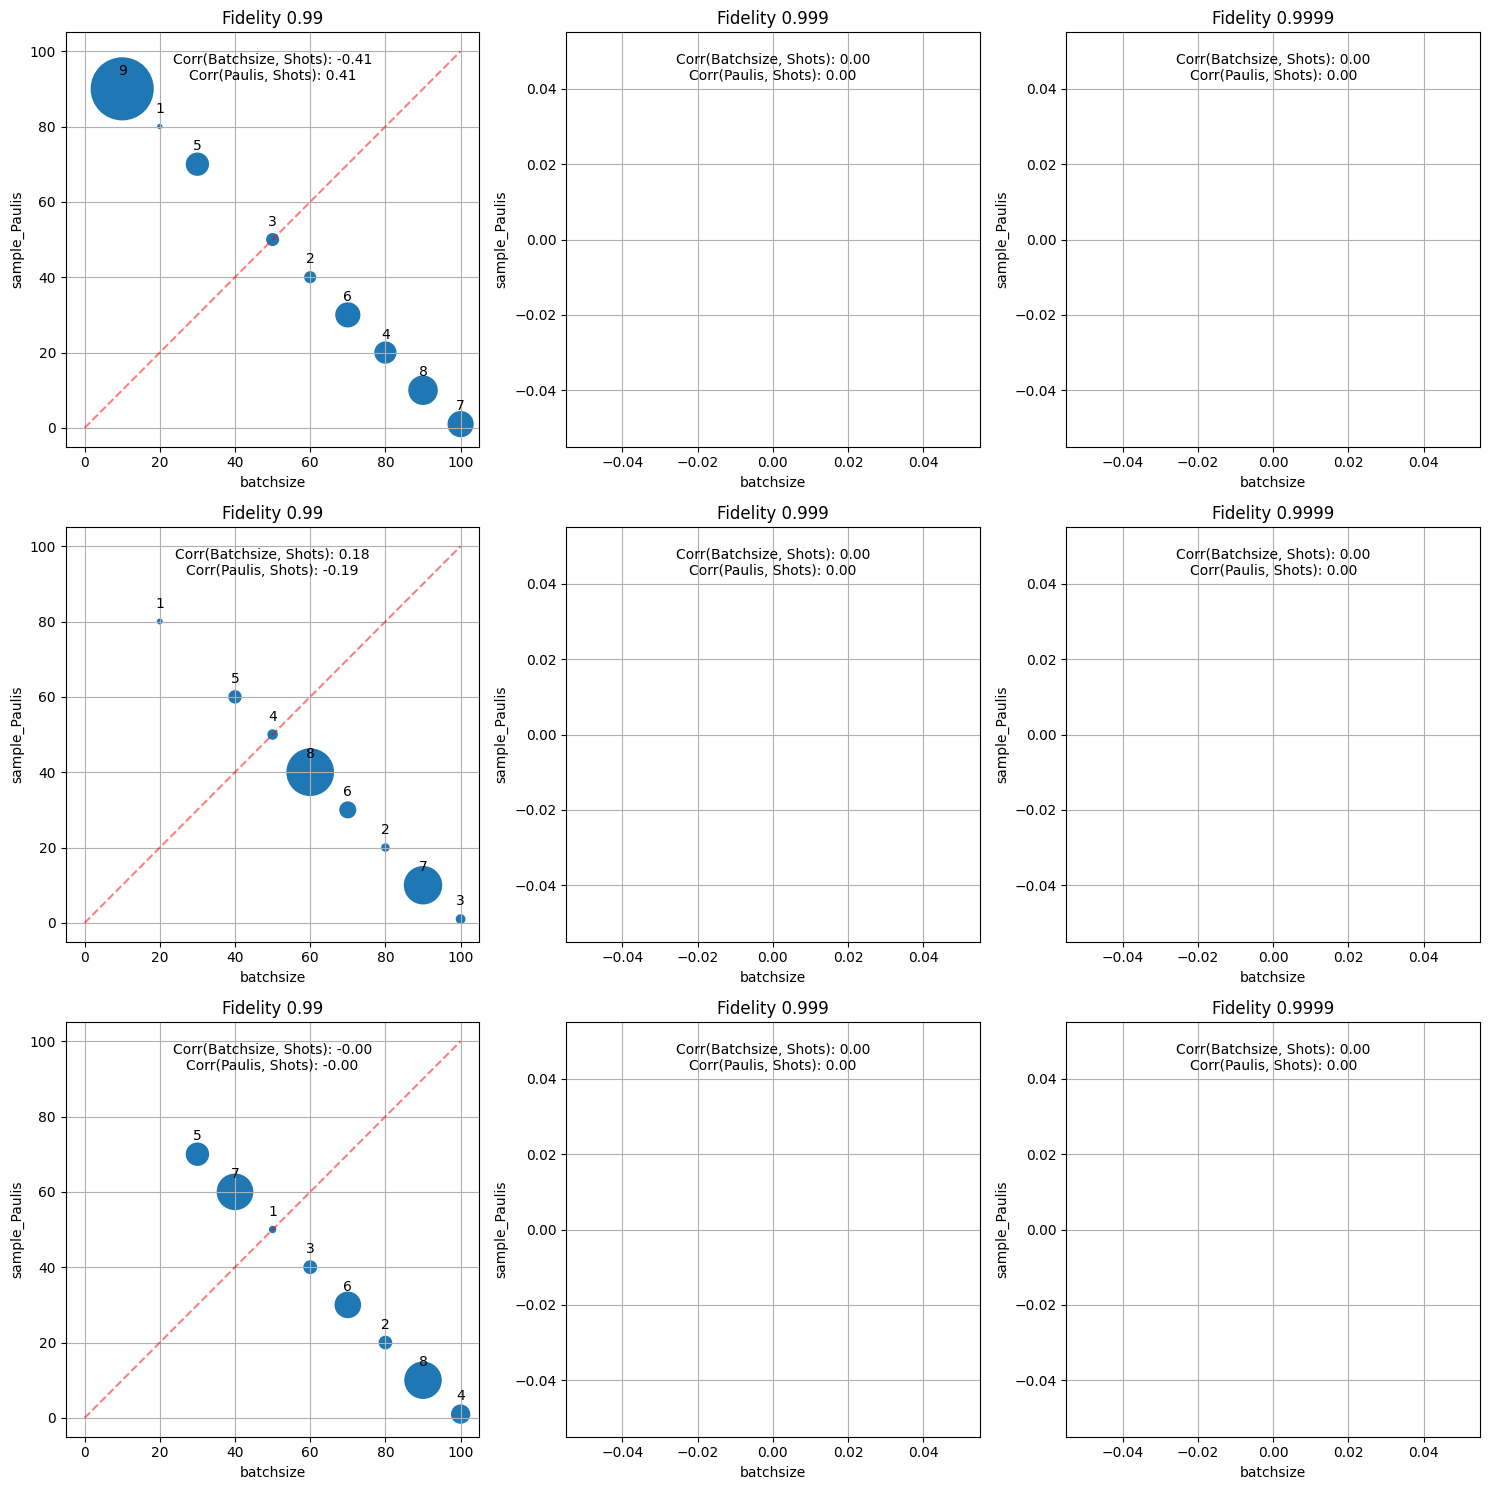

In [40]:
# Assuming multi_seed_dict is structured with 'seed' as outer keys.

# Define fidelity levels
fidelity_levels = [0.99, 0.999, 0.9999]

# Filter data once outside the plotting loop to ensure it matches the required conditions
filtered_data = {
    seed: {key: value for key, value in results.items() 
           if value['fidelity_history'] != [0]
           and value['fidelity_info'][0.99]['shots_used'] is not None}
    for seed, results in multi_seed_dict.items()
}

# Initialize subplots: one row per seed, one column per fidelity level
fig, axs = plt.subplots(len(filtered_data), len(fidelity_levels), figsize=(15, 5 * len(filtered_data)))

# Check if axs is a single dimension array when there's only one row, ensure it's always 2D
if len(filtered_data) == 1:
    axs = [axs]

# Loop over each seed and their results
for row_index, (seed, results) in enumerate(filtered_data.items()):
    # Iterate over fidelity levels and plot data
    for col_index, fidelity_level in enumerate(fidelity_levels):
        # Filter data for the current fidelity level again if needed
        current_filtered_data = {
            (x, y): data for (x, y), data in results.items()
            if data['fidelity_history'] != [0] and data['fidelity_info'][fidelity_level]['shots_used'] is not None
        }

        # Extract x, y, and sizes
        x_values = [xy[0] for xy in current_filtered_data.keys()]  # batchsize
        y_values = [xy[1] for xy in current_filtered_data.keys()]  # sample_paulis
        sizes = [data['fidelity_info'][fidelity_level]['shots_used'] for data in current_filtered_data.values()]  # num_shots

        # Calculate correlations
        if x_values and sizes:
            batchsize_numshots_corr = np.corrcoef(x_values, sizes)[0, 1]
            samplepaulis_numshots_corr = np.corrcoef(y_values, sizes)[0, 1]
        else:
            batchsize_numshots_corr, samplepaulis_numshots_corr = 0, 0  # Avoid error if empty

        # Sorting data based on sizes (number of shots used)
        sorted_data = sorted(zip(x_values, y_values, sizes), key=lambda x: x[2])

        # Unpack sorted data
        x_sorted, y_sorted, sizes_sorted = zip(*sorted_data) if sorted_data else ([], [], [])

        # Plotting for the current fidelity level
        scatter = axs[row_index][col_index].scatter(x_sorted, y_sorted, s=[size / (2.5 * 1e3) for size in sizes_sorted])
        if x_values:
            max_x = max(x_values)
            axs[row_index][col_index].plot([0, max_x], [0, max_x], color='red', linestyle='--', label='Tradeoff line', alpha=0.5)


        # Annotate each point with its rank in reversed order
        for rank, (x, y, size) in enumerate(zip(x_sorted, y_sorted, sizes_sorted), start=1):
            axs[row_index][col_index].annotate(rank, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='black')

        # Add legend and correlation info
        axs[row_index][col_index].text(0.5, 0.95, f'Corr(Batchsize, Shots): {batchsize_numshots_corr:.2f}\nCorr(Paulis, Shots): {samplepaulis_numshots_corr:.2f}',
                                        verticalalignment='top', horizontalalignment='center', transform=axs[row_index][col_index].transAxes, color='black', fontsize=10)

        axs[row_index][col_index].set_title(f'Fidelity {fidelity_level}')
        axs[row_index][col_index].set_xlabel('batchsize')
        axs[row_index][col_index].set_ylabel('sample_Paulis')
        axs[row_index][col_index].grid(True)

plt.tight_layout()
plt.show()

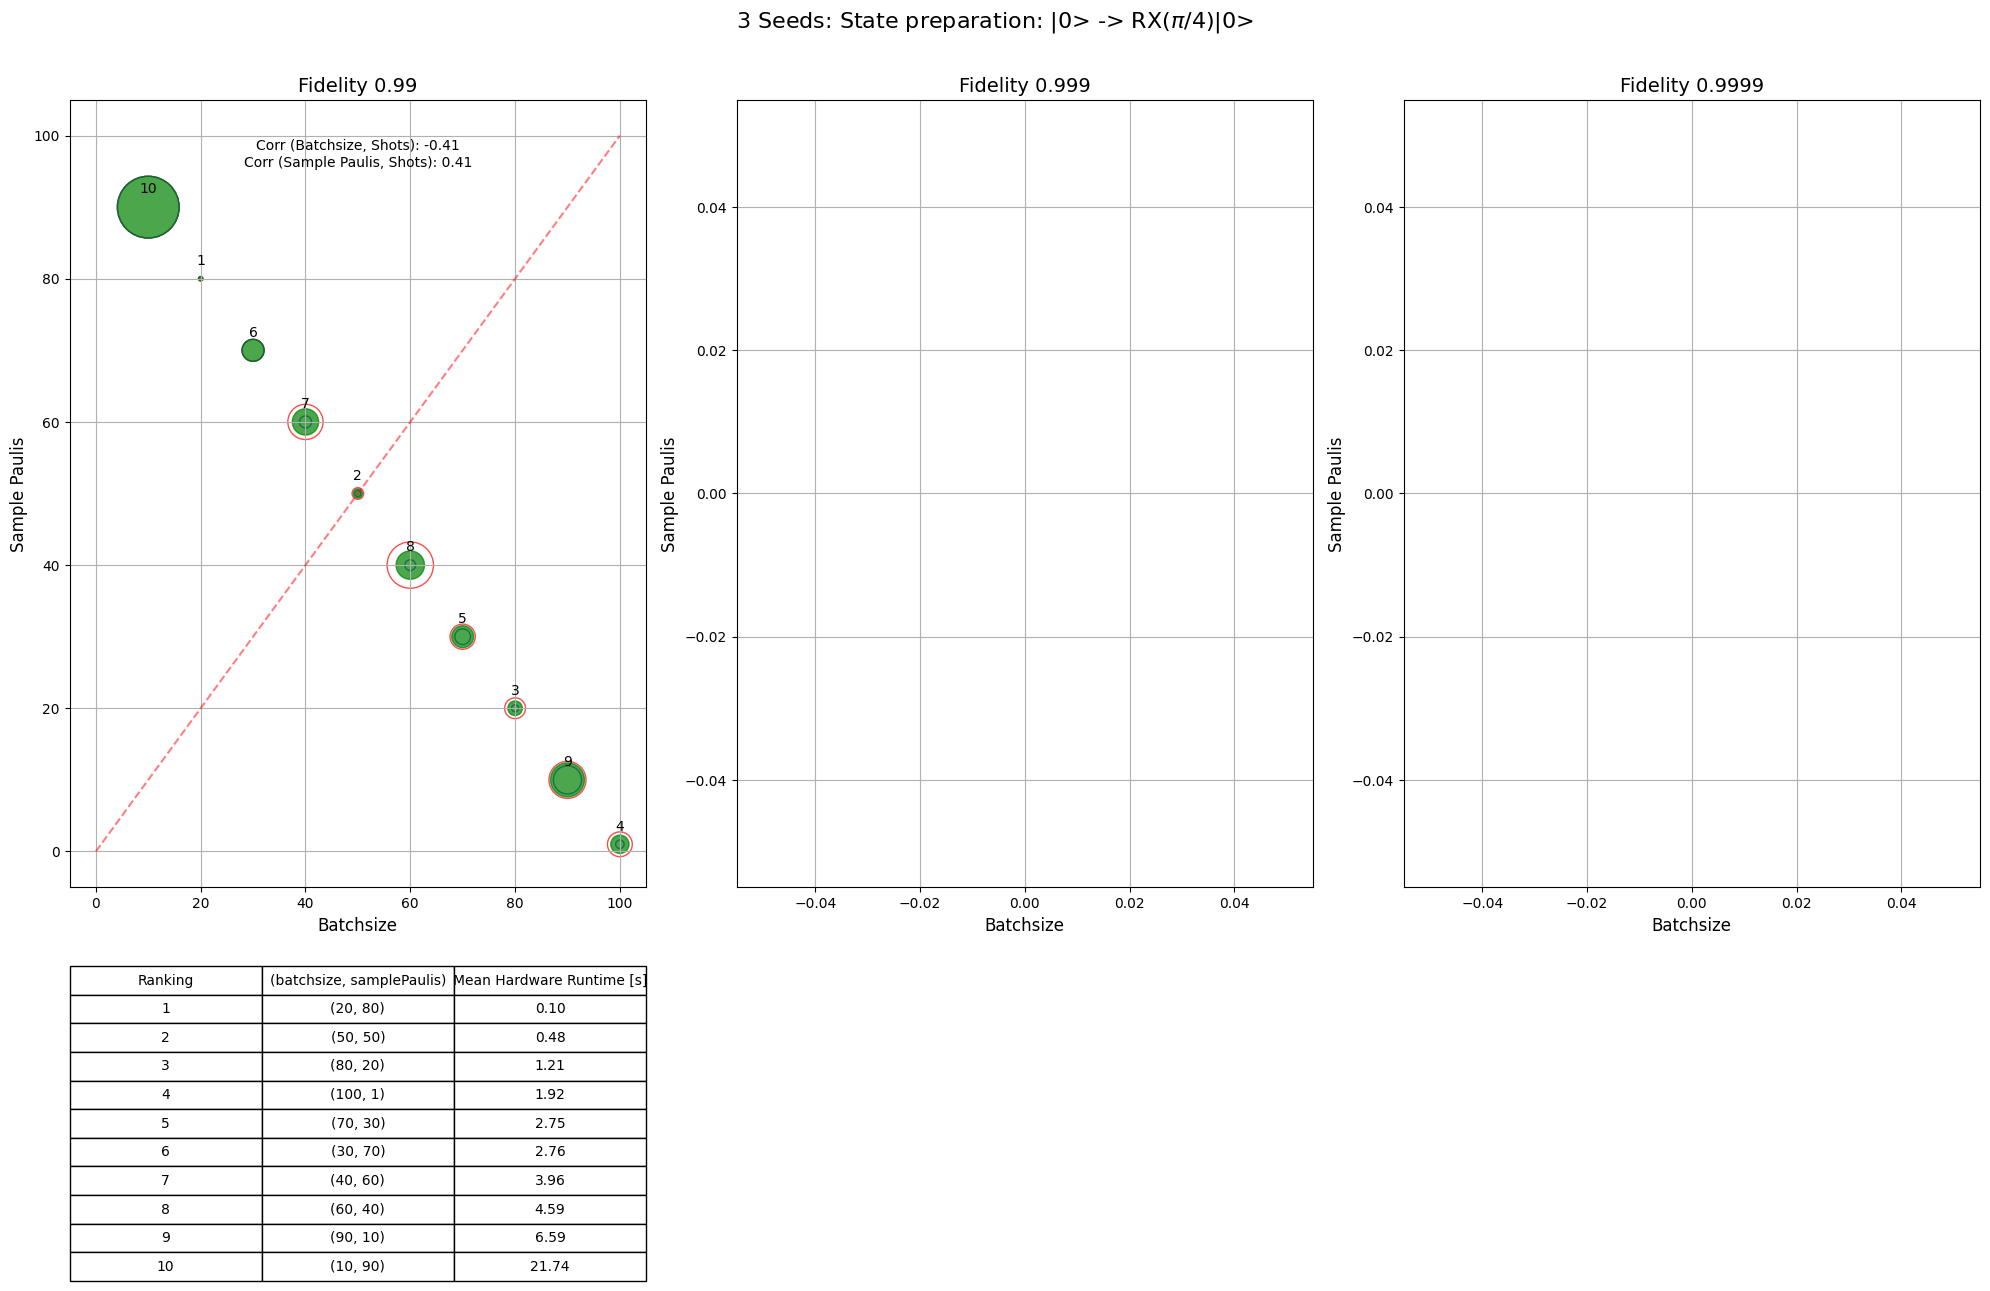

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_data` and `multi_seed_dict` are dictionaries structured as {seed: data}
# Example nested dictionary structure in multi_seed_dict:
# multi_seed_dict[1][(25, 225)]['fidelity_info'][0.99]['hardware_runtime']

# Define fidelity levels
fidelity_levels = [0.99, 0.999, 0.9999]

# Create subplots for each fidelity level
fig, axs = plt.subplots(1, len(fidelity_levels), figsize=(20, 15))  # Increased figure height for more space

batchsize_numshots_corr = {}
samplepaulis_numshots_corr = {}

# Iterate over fidelity levels and plot data
for i, fidelity_level in enumerate(fidelity_levels):
    # Collect data across seeds
    sizes_dict = {}
    runtimes_dict = {}

    # Iterate over seeds
    for seed, data in multi_seed_dict.items():
        for (x, y), d in data.items():
            if d['fidelity_history'] != [0] and d['fidelity_info'][fidelity_level]['shots_used'] is not None:
                if (x, y) not in sizes_dict:
                    sizes_dict[(x, y)] = []
                sizes_dict[(x, y)].append(d['fidelity_info'][fidelity_level]['shots_used'])
                # Collect hardware runtimes
                if (x, y) not in runtimes_dict:
                    runtimes_dict[(x, y)] = []
                runtime = d['fidelity_info'][fidelity_level].get('hardware_runtime', None)
                if runtime is not None:
                    runtimes_dict[(x, y)].append(runtime)

    # Extract x, y, and calculate mean, min, and max of sizes
    x_values = [xy[0] for xy in sizes_dict.keys()]
    y_values = [xy[1] for xy in sizes_dict.keys()]
    sizes_mean = [np.mean(sizes) for sizes in sizes_dict.values()]
    sizes_min = [np.min(sizes) for sizes in sizes_dict.values()]
    sizes_max = [np.max(sizes) for sizes in sizes_dict.values()]

    # Sorting data based on mean sizes (number of shots used) for ranking in ascending order
    sorted_data = sorted(zip(x_values, y_values, sizes_mean, sizes_min, sizes_max), key=lambda x: x[2])

    # Unpack sorted data
    x_sorted, y_sorted, sizes_mean_sorted, sizes_min_sorted, sizes_max_sorted = zip(*sorted_data) if sorted_data else ([], [], [], [], [])

    # Calculate correlation between x_sorted and sizes_mean_sorted
    if len(x_sorted) > 1 and len(sizes_mean_sorted) > 1:
        batchsize_numshots_corr[fidelity_level] = np.corrcoef(x_sorted, sizes_mean_sorted)[0, 1]
        samplepaulis_numshots_corr[fidelity_level] = np.corrcoef(y_sorted, sizes_mean_sorted)[0, 1]
    else:
        batchsize_numshots_corr[fidelity_level] = np.nan
        samplepaulis_numshots_corr[fidelity_level] = np.nan

    # Add correlation text to the plot
    corr_text = f'Corr (Batchsize, Shots): {batchsize_numshots_corr[fidelity_level]:.2f}\nCorr (Sample Paulis, Shots): {samplepaulis_numshots_corr[fidelity_level]:.2f}'
    if not np.all(np.isnan([batchsize_numshots_corr[fidelity_level], samplepaulis_numshots_corr[fidelity_level]])):
        axs[i].text(0.5, 0.95, corr_text, transform=axs[i].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')

    for j, (x, y, mean) in enumerate(zip(x_sorted, y_sorted, sizes_mean_sorted)):
        axs[i].annotate(f'{j+1}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='black')

    # Plotting for the current fidelity level
    axs[i].scatter(x_sorted, y_sorted, s=[size_max / (2.5 * 1e3) for size_max in sizes_max_sorted], facecolors='none', edgecolors='r', alpha=0.7, label='Max Shots')
    axs[i].scatter(x_sorted, y_sorted, s=[size_min / (2.5 * 1e3) for size_min in sizes_min_sorted], facecolors='none', edgecolors='b', alpha=0.7, label='Min Shots')
    axs[i].scatter(x_sorted, y_sorted, s=[mean / (2.5 * 1e3) for mean in sizes_mean_sorted], color='g', alpha=0.7, label='Mean Shots')

    # Add y=x line if x_values is not empty
    if x_values:
        max_x = max(x_values)
        axs[i].plot([0, max_x], [0, max_x], color='red', linestyle='--', label='Tradeoff line', alpha=0.5)

    # Add annotations and decorations
    axs[i].set_title(f'Fidelity {fidelity_level}', fontsize=14)
    axs[i].set_xlabel('Batchsize', fontsize=12)
    axs[i].set_ylabel('Sample Paulis', fontsize=12)
    axs[i].grid(True)

    # Create table for legend
    # Create table for legend
    if len(sorted_data) > 0:
        col_labels = ['Ranking', '(batchsize, samplePaulis)', 'Mean Hardware Runtime [s]']
        table_data = []
        for j, (x, y) in enumerate(zip(x_sorted, y_sorted)):
            runtimes = runtimes_dict.get((x, y), [])
            if runtimes:
                mean_runtime = np.mean(runtimes)
                table_data.append([f'{j+1}', f'({x}, {y})', f'{mean_runtime:.2f}'])
            else:
                table_data.append([f'{j+1}', f'({x}, {y})', 'N/A'])


        # Create the table
        table = axs[i].table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.4])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)  # Scale the table size

plt.suptitle('3 Seeds: State preparation: |0> -> RX($\\pi$/4)|0>', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to make room for the table
plt.subplots_adjust(top=0.92)  # Reduce the space between title and the plots
plt.show()

In [16]:
batchsize_numshots_corr

{0.99: -0.4062988272567146, 0.999: nan, 0.9999: nan}

In [18]:
samplepaulis_numshots_corr

{0.99: 0.4069415850785021, 0.999: nan, 0.9999: nan}

In [2]:
file_seed_1 = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/range_1_to_250/seed_1/state_preparation_target_state-1_bs250_sP1.pickle'
file_seed_2 = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/range_1_to_250/seed_2/state_preparation_target_state-1_bs250_sP1.pickle'
file_seed_3 = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/range_1_to_250/seed_3/state_preparation_target_state-1_bs225_sP25.pickle'

extended_data = {}
for file in [file_seed_1, file_seed_2, file_seed_3]:
    data = load_from_pickle(file)
    extended_data.update(data)

In [3]:
extended_data[1].keys() == extended_data[2].keys() == extended_data[3].keys()

False

In [4]:
extended_data[3].keys()

dict_keys([(1, 250), (25, 225), (50, 200), (75, 175), (100, 150), (125, 125), (150, 100), (175, 75), (200, 50), (225, 25)])

In [5]:
extended_data[1].keys() == extended_data[2].keys()

True

In [6]:
with open('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/range_1_to_250/educational_example_target_state-0.25pi-state_tradeoff_samplePaulis_batchsize_range_1-250_3seeds.pickle', 'wb') as f:
    pickle.dump(extended_data, f)